C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


PSNR для изображения 1: 6.61 dB


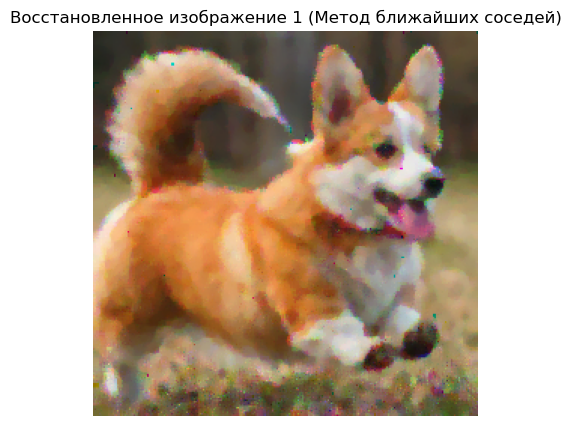

PSNR для изображения 2: 5.52 dB


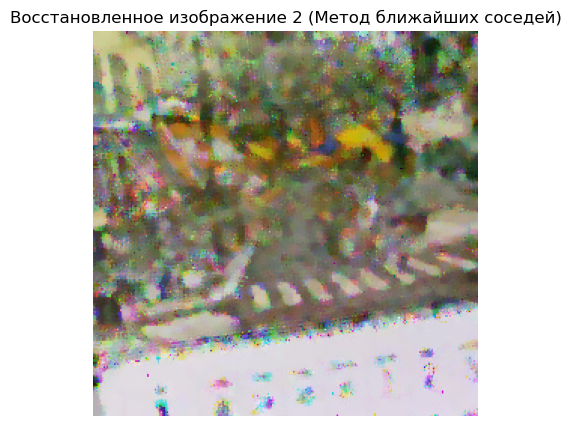

PSNR для изображения 3: 6.84 dB


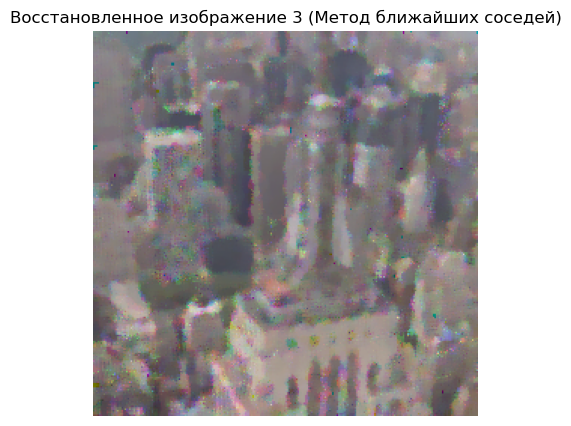

PSNR для изображения 4: 8.27 dB


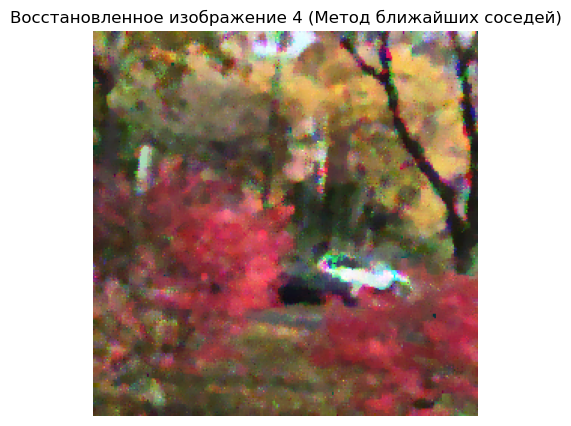

PSNR для изображения 5: 10.61 dB


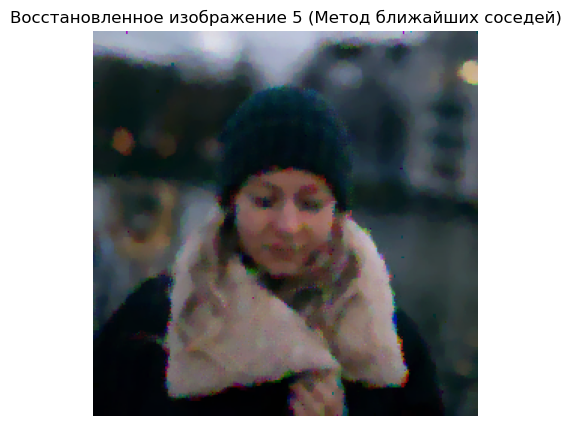

PSNR для изображения 6: 9.81 dB


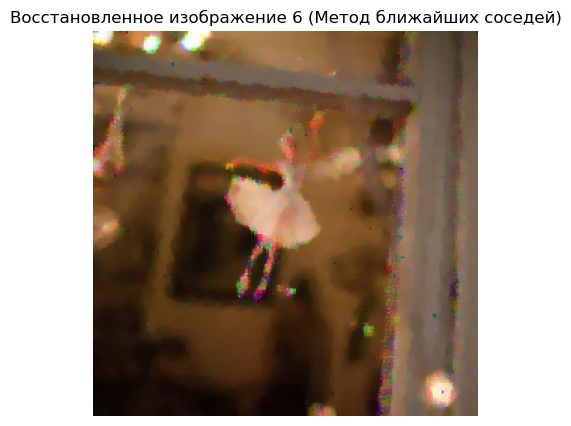

PSNR для изображения 7: 12.97 dB


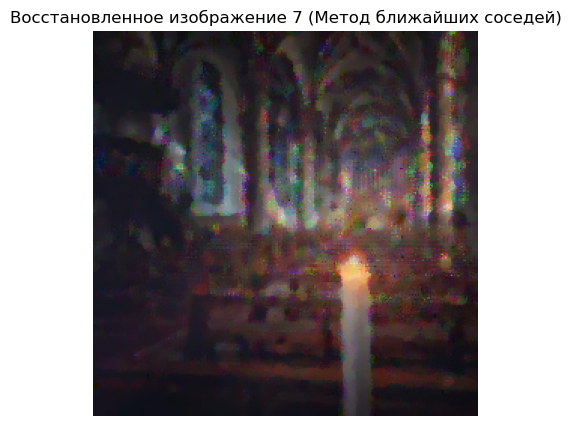

In [1]:
#метод ближайших соседей:)
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter
from skimage.metrics import peak_signal_noise_ratio as psnr


file_path = 'data/565_three_bogatyrs/data.npy'
with open(file_path, 'rb') as file:
    images = np.load(file)


def restore_image_nearest(image):
    def fill_missing(pixel_values):
        center = pixel_values[len(pixel_values) // 2]
        if center == 0:
            return np.median(pixel_values[pixel_values != 0])
        return center
    
    restored_image = np.zeros_like(image)
    
    for i in range(image.shape[-1]):
        channel = image[..., i]
        restored_channel = generic_filter(channel, fill_missing, size=7, mode='constant', cval=0)
        restored_image[..., i] = restored_channel
    return restored_image


restored_images = np.zeros_like(images)

for idx in range(images.shape[0]):
    restored_images[idx] = restore_image_nearest(images[idx])


restored_images_uint8 = np.clip(restored_images, 0, 255).astype(np.uint8)


output_path = 'data/565_three_bogatyrs/restored_images.npy'
with open(output_path, 'wb') as file:
    np.save(file, restored_images_uint8, allow_pickle=False, fix_imports=False)


for idx in range(images.shape[0]):
    psnr_value = psnr(images[idx], restored_images_uint8[idx])
    print(f'PSNR для изображения {idx + 1}: {psnr_value:.2f} dB')
    plt.figure(figsize=(5, 5))
    plt.imshow(restored_images_uint8[idx])
    plt.title(f'Восстановленное изображение {idx + 1} (Метод ближайших соседей)')
    plt.axis('off')
    plt.show()

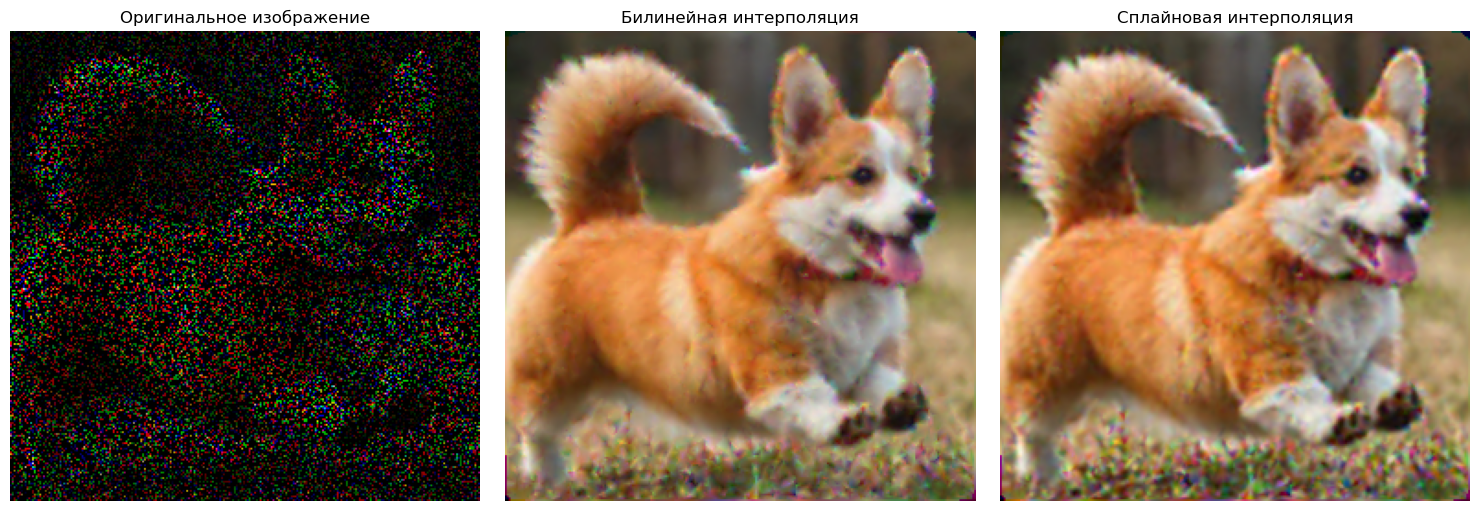

In [11]:
# Восстановление с помощью интерполяции сплайнами
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from skimage.transform import resize


with open('data/565_three_bogatyrs/data.npy', 'rb') as file:
    images = np.load(file)

original_image = images[0]
mask = original_image > 0

def bilinear_interpolation(image, mask):
    h, w, c = image.shape
    restored = np.zeros_like(image, dtype=np.float32)

    for channel in range(c):
        known_points = np.argwhere(mask[:, :, channel])
        known_values = image[:, :, channel][mask[:, :, channel]]
        grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
        restored[:, :, channel] = griddata(
            points=known_points,
            values=known_values,
            xi=(grid_y, grid_x),
            method='linear',
        )
    
    restored[np.isnan(restored)] = 0
    return np.clip(restored, 0, 255)


def spline_interpolation(image, mask):
    h, w, c = image.shape
    restored = np.zeros_like(image, dtype=np.float32)

    for channel in range(c):
        known_points = np.argwhere(mask[:, :, channel])
        known_values = image[:, :, channel][mask[:, :, channel]]
        grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
        restored[:, :, channel] = griddata(
            points=known_points,
            values=known_values,
            xi=(grid_y, grid_x),
            method='cubic',
        )
    
    restored[np.isnan(restored)] = 0
    return np.clip(restored, 0, 255)

bilinear_restored = bilinear_interpolation(original_image, mask)
spline_restored = spline_interpolation(original_image, mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(original_image.astype(np.uint8))
axes[0].set_title("Оригинальное изображение")
axes[0].axis('off')

axes[1].imshow(bilinear_restored.astype(np.uint8))
axes[1].set_title("Билинейная интерполяция")
axes[1].axis('off')

axes[2].imshow(spline_restored.astype(np.uint8))
axes[2].set_title("Сплайновая интерполяция")
axes[2].axis('off')

plt.tight_layout()
plt.show()